In [1]:
############################################################
##### Sysmon Event ID 3 Network Connections Grpah ##########
########## Sysmon Event ID 3 RITA Analysis #################

In [2]:
#Elasticsearch connector
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
import eland as ed
#Data manipulation
import pandas as pd
from pandas.io.json import json_normalize
import json
import re
import eland as ed
import numpy as np
import matplotlib.pyplot as plt
import math
import networkx as nx
import ipaddress
from collections import Counter
import networkx.algorithms.community as nxcom
from datetime import datetime
# Disable warnings"
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
es = Elasticsearch(['https://192.168.1.181:9200'],
ca_certs=False,verify_certs=False, http_auth=('jupyter','password'))
searchContext = Search(using=es, index='*:so-*', doc_type='doc')

In [4]:
query_since_ts = 0
body_filter = '{"query":{"bool":{"filter":[{"range":{"' + '@timestamp' + '":{"gte":' + str(query_since_ts) + '}}}]}},"sort":[{"' + '@timestamp' + '":{"order":"asc"}}]}'
#body_filter = '{"query":{"bool":{"filter":[{"range":{"' + ELASTIC_FIELDS_TS + '":{"gt":' + str(query_since_ts) + '}}}]}},"sort":[{"' + ELASTIC_FIELDS_TS + '":{"order":"asc"}}]}'


In [5]:
#s = searchContext.query('query_string', query='event.code:3')
s = searchContext.query('query_string', query='(event.code:3) AND (destination.port:*)')

In [6]:
response = s.execute()
df = pd.DataFrame(columns=['ts','source.ip','destination.ip','destination.port', 'process.executable'])
if response.success():
    for d in s[:10000]:
        try:
            df = df.append({'ts' : d['@timestamp'], 'source.ip' : d['source']['ip'], 'destination.ip' : d['destination']['ip'], 'destination.port': d['destination']['port'], 'process.executable' : d['process']['executable']}, ignore_index=True)
        except KeyError:
            pass       

display(df)

df.info()

,ts,source.ip,destination.ip,destination.port,process.executable
0,2022-01-01T23:59:12.989Z,192.168.128.7,192.168.120.158,8443,C:\Windows\System32\rundll32.exe
1,2022-01-01T23:58:18.036Z,192.168.128.7,192.168.120.158,8443,C:\Windows\System32\rundll32.exe
2,2022-01-01T23:57:17.073Z,192.168.128.7,192.168.120.158,8443,C:\Windows\System32\rundll32.exe
3,2022-01-01T23:56:18.634Z,192.168.128.7,192.168.120.158,8443,C:\Windows\System32\rundll32.exe
4,2022-01-01T23:55:23.400Z,192.168.128.7,192.168.120.158,8443,C:\Windows\System32\rundll32.exe
...,...,...,...,...,...
6586,2022-01-04T00:02:02.487Z,192.168.128.7,192.168.120.158,8443,C:\Users\Administrator.MYRANGELAB\Downloads\ne...
6587,2022-01-04T00:01:03.443Z,192.168.128.7,192.168.120.158,8443,C:\Windows\System32\rundll32.exe
6588,2022-01-04T00:01:02.424Z,192.168.128.7,192.168.120.158,8443,C:\Users\Administrator.MYRANGELAB\Downloads\ne...
6589,2022-01-04T00:00:03.185Z,192.168.128.7,192.168.120.158,8443,C:\Windows\System32\rundll32.exe


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6591 entries, 0 to 6590
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ts                  6591 non-null   object
 1   source.ip           6591 non-null   object
 2   destination.ip      6591 non-null   object
 3   destination.port    6591 non-null   object
 4   process.executable  6591 non-null   object
dtypes: object(5)
memory usage: 257.6+ KB


In [7]:
json_struct = json.loads(df.to_json(orient="records"))
df_flat = json_normalize(json_struct)
df_flat.head(10)

,ts,source.ip,destination.ip,destination.port,process.executable
0,2022-01-01T23:59:12.989Z,192.168.128.7,192.168.120.158,8443,C:\Windows\System32\rundll32.exe
1,2022-01-01T23:58:18.036Z,192.168.128.7,192.168.120.158,8443,C:\Windows\System32\rundll32.exe
2,2022-01-01T23:57:17.073Z,192.168.128.7,192.168.120.158,8443,C:\Windows\System32\rundll32.exe
3,2022-01-01T23:56:18.634Z,192.168.128.7,192.168.120.158,8443,C:\Windows\System32\rundll32.exe
4,2022-01-01T23:55:23.400Z,192.168.128.7,192.168.120.158,8443,C:\Windows\System32\rundll32.exe
5,2022-01-01T23:54:28.128Z,192.168.128.7,192.168.120.158,8443,C:\Windows\System32\rundll32.exe
6,2022-01-01T23:53:33.905Z,192.168.128.7,192.168.120.158,8443,C:\Windows\System32\rundll32.exe
7,2022-01-01T23:52:39.719Z,192.168.128.7,192.168.120.158,8443,C:\Windows\System32\rundll32.exe
8,2022-01-01T23:51:37.629Z,192.168.128.7,192.168.120.158,8443,C:\Windows\System32\rundll32.exe
9,2022-01-01T23:50:38.609Z,192.168.128.7,192.168.120.158,8443,C:\Windows\System32\rundll32.exe


In [8]:
df['ts'] = pd.to_datetime(df['ts'],infer_datetime_format=True)
df.head(5)

,ts,source.ip,destination.ip,destination.port,process.executable
0,2022-01-01 23:59:12.989000+00:00,192.168.128.7,192.168.120.158,8443,C:\Windows\System32\rundll32.exe
1,2022-01-01 23:58:18.036000+00:00,192.168.128.7,192.168.120.158,8443,C:\Windows\System32\rundll32.exe
2,2022-01-01 23:57:17.073000+00:00,192.168.128.7,192.168.120.158,8443,C:\Windows\System32\rundll32.exe
3,2022-01-01 23:56:18.634000+00:00,192.168.128.7,192.168.120.158,8443,C:\Windows\System32\rundll32.exe
4,2022-01-01 23:55:23.400000+00:00,192.168.128.7,192.168.120.158,8443,C:\Windows\System32\rundll32.exe


In [9]:
print(df.head(5))
print(df.tail(5))

                                ts      source.ip   destination.ip  \
0 2022-01-01 23:59:12.989000+00:00  192.168.128.7  192.168.120.158   
1 2022-01-01 23:58:18.036000+00:00  192.168.128.7  192.168.120.158   
2 2022-01-01 23:57:17.073000+00:00  192.168.128.7  192.168.120.158   
3 2022-01-01 23:56:18.634000+00:00  192.168.128.7  192.168.120.158   
4 2022-01-01 23:55:23.400000+00:00  192.168.128.7  192.168.120.158   

  destination.port                process.executable  
0             8443  C:\Windows\System32\rundll32.exe  
1             8443  C:\Windows\System32\rundll32.exe  
2             8443  C:\Windows\System32\rundll32.exe  
3             8443  C:\Windows\System32\rundll32.exe  
4             8443  C:\Windows\System32\rundll32.exe  
                                   ts      source.ip   destination.ip  \
6586 2022-01-04 00:02:02.487000+00:00  192.168.128.7  192.168.120.158   
6587 2022-01-04 00:01:03.443000+00:00  192.168.128.7  192.168.120.158   
6588 2022-01-04 00:01:02.42400

In [10]:
# assign field/column names to variables
f_timestamp = 'ts'
f_src_ip = 'source.ip'
f_dst_ip = 'destination.ip'
f_dst_port = 'destination.port'
f_process_exe = 'process.executable'
f_delimiter = '\t'

In [11]:
columns_to_filter = [f_timestamp, f_src_ip, f_dst_ip, f_dst_port, f_process_exe]
columns_to_groupby = [f_src_ip, f_dst_ip, f_dst_port,]
# columns to display after the analysis
columns_to_display = ['tsScore','conn_count',f_src_ip,f_dst_ip,f_dst_port, f_process_exe,'deltas']

In [12]:
# If you have a large dateset, using groupby and aggregate(list) might be slow. Consider using dask
df = df.groupby(columns_to_groupby).agg(list)
df.head(50)

ts  \
source.ip       destination.ip  destination.port                                                      
0:0:0:0:0:0:0:1 0:0:0:0:0:0:0:1 5985              [2022-01-01 21:54:27.091000+00:00, 2022-01-01 ...   
192.168.128.10  13.87.187.111   443                              [2022-01-02 06:33:29.356000+00:00]   
                20.62.149.92    443                              [2021-12-30 06:33:30.199000+00:00]   
                20.83.130.102   443               [2022-01-01 06:33:29.489000+00:00, 2022-01-03 ...   
                52.147.223.103  443                              [2021-12-31 06:33:29.403000+00:00]   
192.168.128.11  13.87.187.111   443               [2022-01-01 16:04:19.469000+00:00, 2021-12-30 ...   
                184.85.245.48   443                              [2022-01-02 19:43:21.908000+00:00]   
                20.189.173.4    443               [2022-01-01 21:54:31.224000+00:00, 2022-01-01 ...   
                20.190.157.27   443                              [2022-01-01 21:54:31.999000+00:00]   
                20.190.157.29   443                              [2021-12-31 18:21:17.627000+00:00]   
                20.190.157.30   443                              [2022-01-02 19:43:17.555000+00:00]   
                20.190.157.96   443                              [2021-12-30 18:21:25.383000+00:00]   
                20.36.252.129   443               [2022-01-01 21:54:36.378000+00:00, 2021-12-31 ...   
                20.42.65.84     443                              [2022-01-02 19:43:15.763000+00:00]   
                20.42.65.88     443               [2021-12-30 18:21:23.584000+00:00, 2021-12-30 ...   
                20.42.65.89     443                              [2021-12-31 18:21:14.270000+00:00]   
                20.62.149.92    443               [2021-12-31 16:04:20.029000+00:00, 2022-01-03 ...   
                23.62.213.29    443                              [2021-12-31 18:21:20.172000+00:00]   
                23.77.81.92     443                              [2022-01-01 21:54:36.380000+00:00]   
                52.109.6.45     443               [2022-01-01 21:54:31.475000+00:00, 2021-12-30 ...   
                52.109.8.40     443                              [2021-12-31 18:21:16.096000+00:00]   
                72.21.91.29     80                               [2021-12-30 18:21:28.962000+00:00]   
192.168.128.30  192.168.128.15  5985              [2022-01-04 11:21:57.701000+00:00, 2022-01-04 ...   
                192.168.128.25  5985              [2022-01-04 11:21:33.297000+00:00, 2022-01-04 ...   
                192.168.128.7   5985              [2022-01-04 11:21:41.613000+00:00, 2022-01-04 ...   
192.168.128.50  13.87.187.111   443               [2021-12-30 17:46:38.313000+00:00, 2021-12-30 ...   
                13.91.129.128   443               [2021-12-31 20:11:22.924000+00:00, 2021-12-31 ...   
                192.168.120.158 443               [2022-01-01 19:00:44.447000+00:00, 2021-12-29 ...   
                                80                [2021-12-30 23:59:43.876000+00:00, 2021-12-30 ...   
                                8080              [2022-01-01 18:59:51.267000+00:00, 2022-01-01 ...   
                192.168.128.25  135                              [2021-12-31 00:42:48.714000+00:00]   
                                3268              [2021-12-31 00:43:00.707000+00:00, 2021-12-31 ...   
                                389               [2021-12-31 00:43:00.707000+00:00, 2021-12-31 ...   
                                49666                            [2021-12-31 00:42:48.714000+00:00]   
                                53                [2022-01-01 19:13:07.313000+00:00, 2021-12-31 ...   
                20.62.149.92    443                              [2021-12-31 00:42:34.887000+00:00]   
                20.83.130.102   443               [2022-01-01 18:59:31.702000+00:00, 2021-12-30 ...   
                52.147.223.103  443               [2022-01-01 17:43:53.034000+00

In [13]:
df.reset_index(inplace=True)
df.head(5)

,source.ip,destination.ip,destination.port,ts,process.executable
0,0:0:0:0:0:0:0:1,0:0:0:0:0:0:0:1,5985,"[2022-01-01 21:54:27.091000+00:00, 2022-01-01 ...","[System, C:\WINDOWS\System32\svchost.exe, C:\W..."
1,192.168.128.10,13.87.187.111,443,[2022-01-02 06:33:29.356000+00:00],[C:\ProgramData\Microsoft\Windows Defender\Pla...
2,192.168.128.10,20.62.149.92,443,[2021-12-30 06:33:30.199000+00:00],[C:\ProgramData\Microsoft\Windows Defender\Pla...
3,192.168.128.10,20.83.130.102,443,"[2022-01-01 06:33:29.489000+00:00, 2022-01-03 ...",[C:\ProgramData\Microsoft\Windows Defender\Pla...
4,192.168.128.10,52.147.223.103,443,[2021-12-31 06:33:29.403000+00:00],[C:\ProgramData\Microsoft\Windows Defender\Pla...


In [14]:
pd.set_option("display.max_rows", None)
pd.set_option("max_colwidth", None)
pd.set_option("display.max_columns", None)
df.head(50)

,source.ip,destination.ip,destination.port,ts,process.executable
0,0:0:0:0:0:0:0:1,0:0:0:0:0:0:0:1,5985,"[2022-01-01 21:54:27.091000+00:00, 2022-01-01 21:54:27.091000+00:00, 2022-01-01 21:54:26.821000+00:00, 2022-01-01 21:54:26.821000+00:00, 2022-01-01 19:18:52.825000+00:00, 2022-01-01 19:18:52.303000+00:00, 2022-01-01 19:18:52.303000+00:00, 2022-01-01 19:18:52.040000+00:00, 2022-01-01 18:53:05.112000+00:00, 2022-01-01 18:53:05.112000+00:00, 2022-01-01 18:53:04.609000+00:00, 2022-01-01 18:53:04.609000+00:00, 2022-01-01 14:44:31.798000+00:00, 2022-01-01 14:44:31.798000+00:00, 2022-01-01 14:44:31.797000+00:00, 2022-01-01 14:44:31.797000+00:00, 2022-01-01 06:53:28.638000+00:00, 2022-01-01 06:53:28.127000+00:00, 2022-01-01 06:53:28.127000+00:00, 2022-01-01 06:53:27.859000+00:00, 2021-12-29 19:18:53.532000+00:00, 2021-12-29 19:18:53.530000+00:00, 2021-12-29 19:18:52.771000+00:00, 2021-12-29 19:18:52.771000+00:00, 2021-12-30 19:18:52.595000+00:00, 2021-12-30 19:18:52.345000+00:00, 2021-12-30 19:18:51.832000+00:00, 2021-12-30 19:18:51.566000+00:00, 2021-12-30 18:21:18.429000+00:00, 2021-12-30 18:21:18.180000+00:00, 2021-12-30 18:21:17.659000+00:00, 2021-12-30 18:21:17.400000+00:00, 2021-12-30 15:17:30.271000+00:00, 2021-12-30 15:17:30.271000+00:00, 2021-12-30 15:17:30.020000+00:00, 2021-12-30 15:17:30.019000+00:00, 2021-12-31 19:18:51.844000+00:00, 2021-12-31 19:18:51.844000+00:00, 2021-12-31 19:18:51.580000+00:00, 2021-12-31 19:18:51.580000+00:00, 2021-12-31 18:21:11.167000+00:00, 2021-12-31 18:21:11.167000+00:00, 2021-12-31 18:21:10.908000+00:00, 2021-12-31 18:21:10.908000+00:00, 2021-12-31 14:44:43.596000+00:00, 2021-12-31 14:44:42.860000+00:00, 2021-12-31 14:44:42.860000+00:00, 2021-12-31 14:44:42.165000+00:00, 2022-01-02 19:43:13.443000+00:00, 2022-01-02 19:43:12.665000+00:00, 2022-01-02 19:43:12.665000+00:00, 2022-01-02 19:43:12.664000+00:00, 2022-01-02 19:18:53.240000+00:00, 2022-01-02 19:18:52.726000+00:00, 2022-01-02 19:18:52.471000+00:00, 2022-01-02 19:18:51.967000+00:00, 2022-01-02 18:55:19.789000+00:00, 2022-01-02 18:55:19.789000+00:00, 2022-01-02 18:55:19.272000+00:00, 2022-01-02 18:55:19.272000+00:00, 2022-01-02 17:54:58.074000+00:00, 2022-01-02 17:54:58.074000+00:00, 2022-01-02 17:54:57.823000+00:00, 2022-01-02 17:54:57.823000+00:00, 2022-01-02 14:44:32.132000+00:00, 2022-01-02 14:44:31.358000+00:00, 2022-01-02 14:44:30.840000+00:00, 2022-01-02 14:44:30.840000+00:00, 2022-01-02 09:19:23.912000+00:00, 2022-01-02 09:19:23.912000+00:00, 2022-01-02 09:19:23.911000+00:00, 2022-01-02 09:19:23.911000+00:00, 2022-01-02 05:32:21.985000+00:00, 2022-01-02 05:32:21.114000+00:00, 2022-01-02 05:32:20.862000+00:00, 2022-01-02 05:32:20.862000+00:00, 2022-01-02 01:40:12.903000+00:00, 2022-01-02 01:40:12.903000+00:00, 2022-01-02 01:40:12.402000+00:00, 2022-01-02 01:40:12.402000+00:00, 2022-01-03 19:24:18.519000+00:00, 2022-01-03 19:24:18.518000+00:00, 2022-01-03 19:24:18.253000+00:00, 2022-01-03 19:24:18.253000+00:00, 2022-01-03 18:23:59.793000+00:00, 2022-01-03 18:23:59.793000+00:00, 2022-01-03 18:23:59.528000+00:00, 2022-01-03 18:23:59.527000+00:00, 2022-01-03 16:18:03.307000+00:00, 2022-01-03 16:18:03.307000+00:00, 2022-01-03 16:18:03.307000+00:00, 2022-01-03 16:18:03.307000+00:00, 2022-01-03 12:24:38.729000+00:00, 2022-01-03 12:24:38.729000+00:00, 2022-01-03 12:24:37.933000+00:00, 2022-01-03 12:24:37.933000+00:00, 2022-01-03 12:03:29.540000+00:00, 2022-01-03 12:03:29.540000+00:00, 2022-01-03 12:03:28.766000+00:00, 2022-01-03 12:03:27.908000+00:00, ...]","[System, C:\WINDOWS\System32\svchost.exe, C:\WINDOWS\System32\svchost.exe, System, C:\WINDOWS\System32\svchost.exe, C:\WINDOWS\System32\svchost.exe, System, System, System, C:\WINDOWS\System32\svchost.exe, C:\WINDOWS\System32\svchost.exe, System, System, C:\WINDOWS\System32\svchost.exe, System, C:\WINDOWS\System32\svchost.exe, C:\WINDOWS\System32\svchost.exe, C:\WINDOWS\System32\svchost.exe, System, System, C:\WINDOWS\System32\svchost.exe, C:\WINDOWS\System32\svchost.exe, System, Sy

In [15]:
# create a new column 'conn_count', and for each row in the 'ts' column, apply a function and assign the returned value to the 'conn_count' column
df['conn_count'] = df[f_timestamp].apply(lambda x: len(x))
#df['conn_count'] = df[f_process_exe].apply(lambda x: len(x))
df.head()

,source.ip,destination.ip,destination.port,ts,process.executable,conn_count
0,0:0:0:0:0:0:0:1,0:0:0:0:0:0:0:1,5985,"[2022-01-01 21:54:27.091000+00:00, 2022-01-01 21:54:27.091000+00:00, 2022-01-01 21:54:26.821000+00:00, 2022-01-01 21:54:26.821000+00:00, 2022-01-01 19:18:52.825000+00:00, 2022-01-01 19:18:52.303000+00:00, 2022-01-01 19:18:52.303000+00:00, 2022-01-01 19:18:52.040000+00:00, 2022-01-01 18:53:05.112000+00:00, 2022-01-01 18:53:05.112000+00:00, 2022-01-01 18:53:04.609000+00:00, 2022-01-01 18:53:04.609000+00:00, 2022-01-01 14:44:31.798000+00:00, 2022-01-01 14:44:31.798000+00:00, 2022-01-01 14:44:31.797000+00:00, 2022-01-01 14:44:31.797000+00:00, 2022-01-01 06:53:28.638000+00:00, 2022-01-01 06:53:28.127000+00:00, 2022-01-01 06:53:28.127000+00:00, 2022-01-01 06:53:27.859000+00:00, 2021-12-29 19:18:53.532000+00:00, 2021-12-29 19:18:53.530000+00:00, 2021-12-29 19:18:52.771000+00:00, 2021-12-29 19:18:52.771000+00:00, 2021-12-30 19:18:52.595000+00:00, 2021-12-30 19:18:52.345000+00:00, 2021-12-30 19:18:51.832000+00:00, 2021-12-30 19:18:51.566000+00:00, 2021-12-30 18:21:18.429000+00:00, 2021-12-30 18:21:18.180000+00:00, 2021-12-30 18:21:17.659000+00:00, 2021-12-30 18:21:17.400000+00:00, 2021-12-30 15:17:30.271000+00:00, 2021-12-30 15:17:30.271000+00:00, 2021-12-30 15:17:30.020000+00:00, 2021-12-30 15:17:30.019000+00:00, 2021-12-31 19:18:51.844000+00:00, 2021-12-31 19:18:51.844000+00:00, 2021-12-31 19:18:51.580000+00:00, 2021-12-31 19:18:51.580000+00:00, 2021-12-31 18:21:11.167000+00:00, 2021-12-31 18:21:11.167000+00:00, 2021-12-31 18:21:10.908000+00:00, 2021-12-31 18:21:10.908000+00:00, 2021-12-31 14:44:43.596000+00:00, 2021-12-31 14:44:42.860000+00:00, 2021-12-31 14:44:42.860000+00:00, 2021-12-31 14:44:42.165000+00:00, 2022-01-02 19:43:13.443000+00:00, 2022-01-02 19:43:12.665000+00:00, 2022-01-02 19:43:12.665000+00:00, 2022-01-02 19:43:12.664000+00:00, 2022-01-02 19:18:53.240000+00:00, 2022-01-02 19:18:52.726000+00:00, 2022-01-02 19:18:52.471000+00:00, 2022-01-02 19:18:51.967000+00:00, 2022-01-02 18:55:19.789000+00:00, 2022-01-02 18:55:19.789000+00:00, 2022-01-02 18:55:19.272000+00:00, 2022-01-02 18:55:19.272000+00:00, 2022-01-02 17:54:58.074000+00:00, 2022-01-02 17:54:58.074000+00:00, 2022-01-02 17:54:57.823000+00:00, 2022-01-02 17:54:57.823000+00:00, 2022-01-02 14:44:32.132000+00:00, 2022-01-02 14:44:31.358000+00:00, 2022-01-02 14:44:30.840000+00:00, 2022-01-02 14:44:30.840000+00:00, 2022-01-02 09:19:23.912000+00:00, 2022-01-02 09:19:23.912000+00:00, 2022-01-02 09:19:23.911000+00:00, 2022-01-02 09:19:23.911000+00:00, 2022-01-02 05:32:21.985000+00:00, 2022-01-02 05:32:21.114000+00:00, 2022-01-02 05:32:20.862000+00:00, 2022-01-02 05:32:20.862000+00:00, 2022-01-02 01:40:12.903000+00:00, 2022-01-02 01:40:12.903000+00:00, 2022-01-02 01:40:12.402000+00:00, 2022-01-02 01:40:12.402000+00:00, 2022-01-03 19:24:18.519000+00:00, 2022-01-03 19:24:18.518000+00:00, 2022-01-03 19:24:18.253000+00:00, 2022-01-03 19:24:18.253000+00:00, 2022-01-03 18:23:59.793000+00:00, 2022-01-03 18:23:59.793000+00:00, 2022-01-03 18:23:59.528000+00:00, 2022-01-03 18:23:59.527000+00:00, 2022-01-03 16:18:03.307000+00:00, 2022-01-03 16:18:03.307000+00:00, 2022-01-03 16:18:03.307000+00:00, 2022-01-03 16:18:03.307000+00:00, 2022-01-03 12:24:38.729000+00:00, 2022-01-03 12:24:38.729000+00:00, 2022-01-03 12:24:37.933000+00:00, 2022-01-03 12:24:37.933000+00:00, 2022-01-03 12:03:29.540000+00:00, 2022-01-03 12:03:29.540000+00:00, 2022-01-03 12:03:28.766000+00:00, 2022-01-03 12:03:27.908000+00:00, ...]","[System, C:\WINDOWS\System32\svchost.exe, C:\WINDOWS\System32\svchost.exe, System, C:\WINDOWS\System32\svchost.exe, C:\WINDOWS\System32\svchost.exe, System, System, System, C:\WINDOWS\System32\svchost.exe, C:\WINDOWS\System32\svchost.exe, System, System, C:\WINDOWS\System32\svchost.exe, System, C:\WINDOWS\System32\svchost.exe, C:\WINDOWS\System32\svchost.exe, C:\WINDOWS\System32\svchost.exe, System, System, C:\WINDOWS\System32\svchost.exe, C:\WINDOWS\System32\svchost.exe,

In [16]:
# Recast float types to int
df["conn_count"] = df["conn_count"].astype("int64")
df["destination.port"] = df["destination.port"].astype("int64")

In [17]:
# Calculate the weights based off of the count of unique Suricata alerts

maxconncount=df["conn_count"].max()

df["connweight"] = df.apply(lambda x: 10/maxconncount*x.conn_count+0.1, axis=1)

In [18]:
# Show the min/max values for both calculated weights


print(df.connweight.min())
print(df.connweight.max())
# Show first and last 5 records
print(df.head(5))
print(df.tail(5))

0.101943256898562
10.1
         source.ip   destination.ip  destination.port  \
0  0:0:0:0:0:0:0:1  0:0:0:0:0:0:0:1              5985   
1   192.168.128.10    13.87.187.111               443   
2   192.168.128.10     20.62.149.92               443   
3   192.168.128.10    20.83.130.102               443   
4   192.168.128.10   52.147.223.103               443   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [19]:
# Create graphs
# Create our graph from our pandas dataframe
G = nx.from_pandas_edgelist(df, source="source.ip", target="destination.ip", edge_key="destination.port", edge_attr=True, create_using=nx.MultiDiGraph())
G2 = nx.from_pandas_edgelist(df, source="source.ip", target="destination.ip", edge_attr=True, create_using=nx.Graph())


In [20]:
# add our node attributes
# List of desired source attributes:
src_attributes = [ "connweight"]

# Iterate over df rows and set source node attributes:
for index, row in df.iterrows():
    src_attr_dict = {k: row.to_dict()[k] for k in src_attributes}    
    G.nodes[row["source.ip"]].update(src_attr_dict)
    G.nodes[row["destination.ip"]].update(src_attr_dict)

In [21]:
# Check how many nodes the graph contains to set attributes for figure size
n = len(G.nodes)
if n > 30:
    largegraph=True
    fig_size = (20,20)
    print("Large Graph: %s , using large graph functions" % n)
if n <= 500 > 999:
    fig_size = (40,30)
    largegraph=False
    print("Small Graph: %s figsize: %s" % (n, fig_size))
if n <= 250  > 499 :
    fig_size = (30,20)
    largegraph=False
    print("Small Graph: %s figsize: %s" % (n, fig_size))
if n < 100 > 0:
    fig_size = (18,15)
    largegraph=False
    print("Small Graph: %s figsize: %s" % (n, fig_size))

Large Graph: 32 , using large graph functions
Small Graph: 32 figsize: (18, 15)


In [22]:
print("Graph analysis\n")
print("Multi-edge directed Graph\n")
print("Number of nodes: %s\t" % len(G.nodes))
print("Number of edges: %s\n" % len(G.edges))
print("Graph density: %s\n" % nx.density(G))
print("Graph is directed: %s\n" % G.is_directed())
print("Graph is weighted: %s\n" % nx.is_weighted(G))
print("Undirected Graph\n")
print("Transitivity: %s" % nx.transitivity(G2))
print("Average clustering coefficient: %s" % nx.average_clustering(G2))
communities = sorted(nxcom.greedy_modularity_communities(G2), key=len, reverse=True)
print("Greedy Modularity Communities: %s" % len(communities))

Graph analysis

Multi-edge directed Graph

Number of nodes: 32	
Number of edges: 51

Graph density: 0.05141129032258065

Graph is directed: True

Graph is weighted: False

Undirected Graph

Transitivity: 0
Average clustering coefficient: 0.0
Greedy Modularity Communities: 4


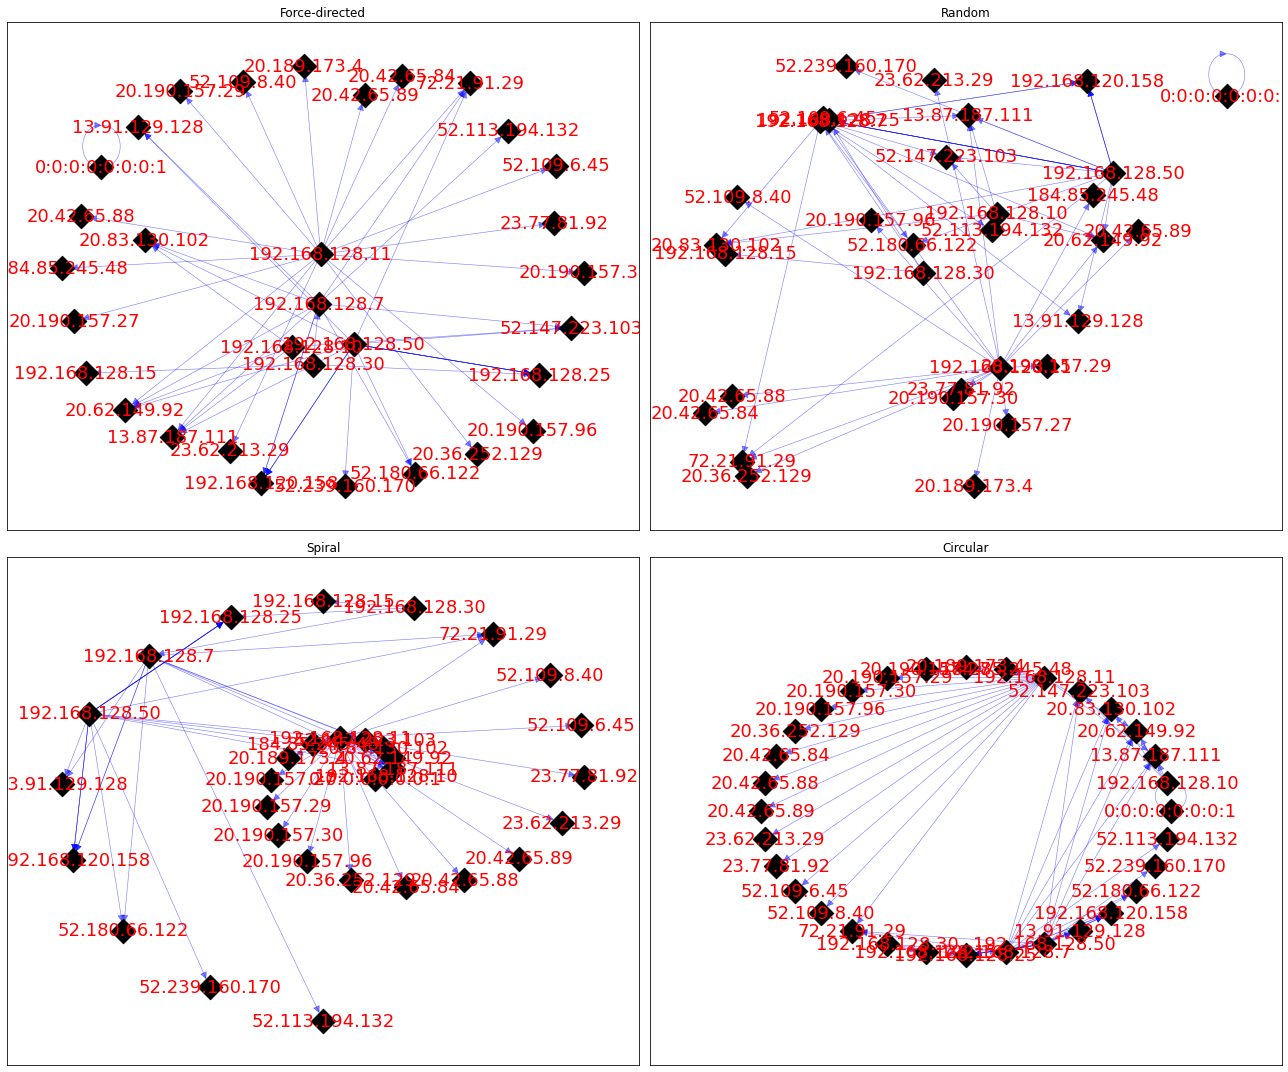

In [23]:
# Draw our graph
#Define our Graph Plot Layouts
layouts = (nx.spring_layout, nx.random_layout, nx.spiral_layout, nx.circular_layout)
title = ("Force-directed", "Random", "Spiral", "Circular")
## Create our Plots
# Create 4 subplots with the figure size based on graph size
_, plot = plt.subplots(2, 2, figsize=fig_size)
subplots = plot.reshape(1, 4)[0]
# Draw a plot for each layout
for plot, layout, title in zip(subplots, layouts, title):
    pos = layout(G)
    nx.draw_networkx_edges(G, pos, ax=plot, width=0.6, style="solid", edge_color="blue", alpha=0.5, arrows=True, arrowsize=15, arrowstyle="-|>")
    nx.draw_networkx_nodes(G, pos, ax=plot, node_color="black", node_shape="D")
    # Draw labels
    nx.draw_networkx_labels(G, pos, ax=plot, font_color="red", font_size=18)
    plot.set_title(title)
# Draw with tight layout https://matplotlib.org/tutorials/intermediate/tight_layout_guide.html
plt.gca().margins(0.20, 0.30)
plt.tight_layout()
plt.show(block=False)

In [24]:
#Filter out traffic where the connection count is quite small
df = df.loc[df['conn_count'] > 50]
df.shape

(5, 7)

In [25]:
# Recast float types to int
df["conn_count"] = df["conn_count"].astype("int64")
df["destination.port"] = df["destination.port"].astype("int64")

In [26]:
# Calculate the weights based off of the count of unique Suricata alerts

maxconncount=df["conn_count"].max()

df["connweight"] = df.apply(lambda x: 10/maxconncount*x.conn_count+0.1, axis=1)

In [27]:
# Show the min/max values for both calculated weights


print(df.connweight.min())
print(df.connweight.max())
# Show first and last 5 records
print(df.head(5))
print(df.tail(5))

0.1991061018266615
10.1
          source.ip   destination.ip  destination.port  \
0   0:0:0:0:0:0:0:1  0:0:0:0:0:0:0:1              5985   
27   192.168.128.50  192.168.120.158               443   
28   192.168.128.50  192.168.120.158                80   
32   192.168.128.50   192.168.128.25               389   
44    192.168.128.7  192.168.120.158              8443   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [28]:
# Create graphs
# Create our graph from our pandas dataframe
G = nx.from_pandas_edgelist(df, source="source.ip", target="destination.ip", edge_key="destination.port", edge_attr=True, create_using=nx.MultiDiGraph())
G2 = nx.from_pandas_edgelist(df, source="source.ip", target="destination.ip", edge_attr=True, create_using=nx.Graph())


In [29]:
# add our node attributes
# List of desired source attributes:
src_attributes = [ "connweight"]

# Iterate over df rows and set source node attributes:
for index, row in df.iterrows():
    src_attr_dict = {k: row.to_dict()[k] for k in src_attributes}    
    G.nodes[row["source.ip"]].update(src_attr_dict)
    G.nodes[row["destination.ip"]].update(src_attr_dict)

In [30]:
# Check how many nodes the graph contains to set attributes for figure size
n = len(G.nodes)
if n > 30:
    largegraph=True
    fig_size = (20,40)
    print("Large Graph: %s , using large graph functions" % n)
if n <= 500 > 999:
    fig_size = (40,30)
    largegraph=False
    print("Small Graph: %s figsize: %s" % (n, fig_size))
if n <= 250  > 499 :
    fig_size = (30,20)
    largegraph=False
    print("Small Graph: %s figsize: %s" % (n, fig_size))
if n < 100 > 0:
    fig_size = (18,15)
    largegraph=False
    print("Small Graph: %s figsize: %s" % (n, fig_size))

Small Graph: 5 figsize: (18, 15)


In [31]:
print("Graph analysis\n")
print("Multi-edge directed Graph\n")
print("Number of nodes: %s\t" % len(G.nodes))
print("Number of edges: %s\n" % len(G.edges))
print("Graph density: %s\n" % nx.density(G))
print("Graph is directed: %s\n" % G.is_directed())
print("Graph is weighted: %s\n" % nx.is_weighted(G))
print("Undirected Graph\n")
print("Transitivity: %s" % nx.transitivity(G2))
print("Average clustering coefficient: %s" % nx.average_clustering(G2))
communities = sorted(nxcom.greedy_modularity_communities(G2), key=len, reverse=True)
print("Greedy Modularity Communities: %s" % len(communities))

Graph analysis

Multi-edge directed Graph

Number of nodes: 5	
Number of edges: 5

Graph density: 0.25

Graph is directed: True

Graph is weighted: False

Undirected Graph

Transitivity: 0
Average clustering coefficient: 0.0
Greedy Modularity Communities: 3


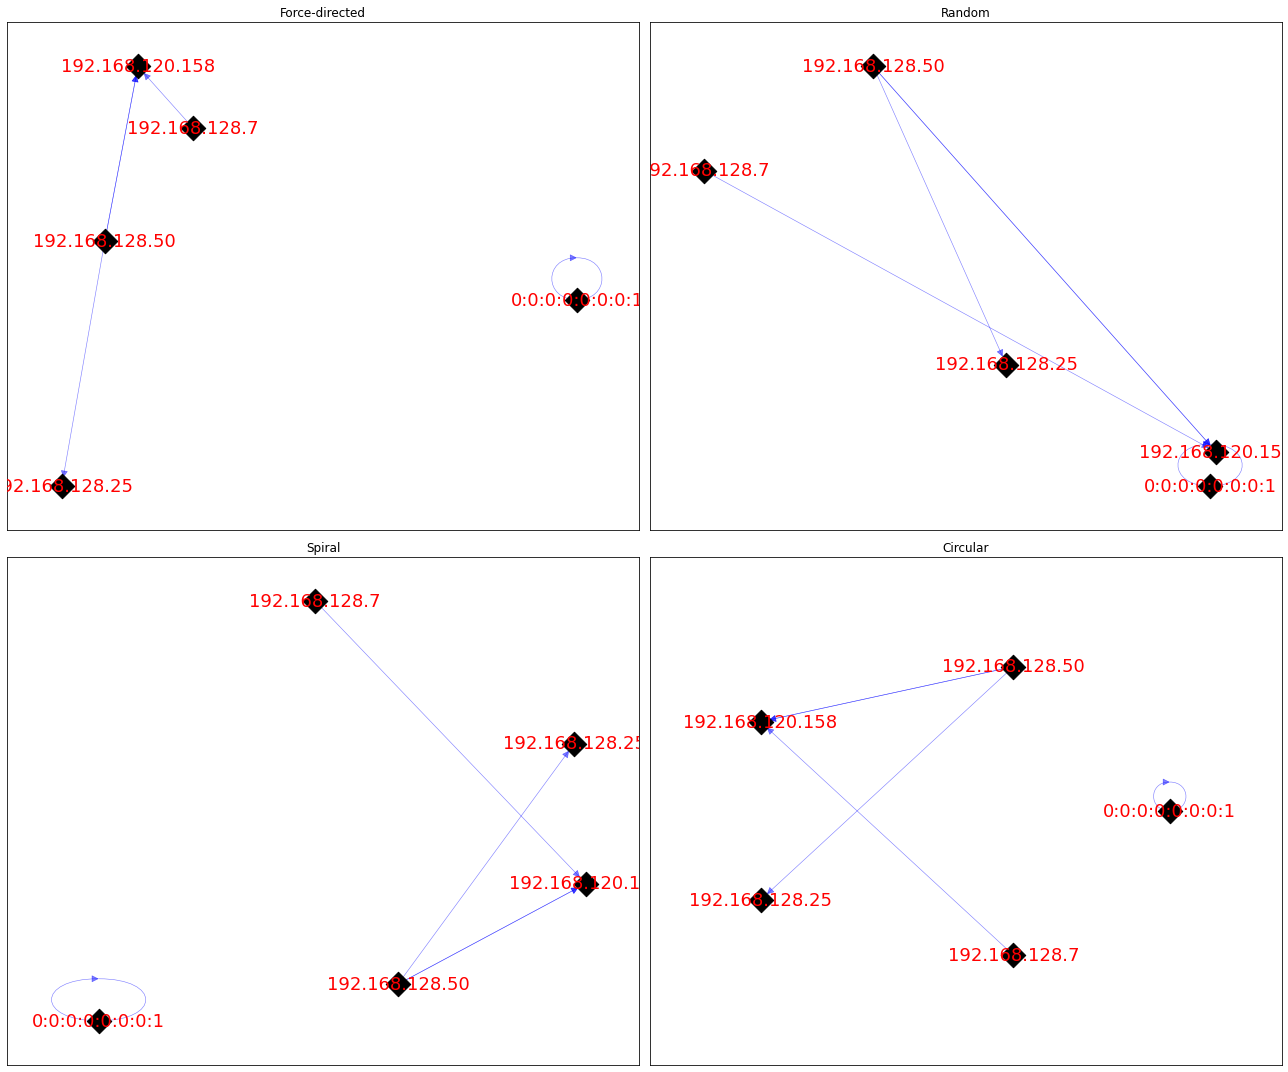

In [32]:
# Draw our graph
#Define our Graph Plot Layouts
layouts = (nx.spring_layout, nx.random_layout, nx.spiral_layout, nx.circular_layout)
title = ("Force-directed", "Random", "Spiral", "Circular")
## Create our Plots
# Create 4 subplots with the figure size based on graph size
_, plot = plt.subplots(2, 2, figsize=fig_size)
subplots = plot.reshape(1, 4)[0]
# Draw a plot for each layout
for plot, layout, title in zip(subplots, layouts, title):
    pos = layout(G)
    nx.draw_networkx_edges(G, pos, ax=plot, width=0.6, style="solid", edge_color="blue", alpha=0.5, arrows=True, arrowsize=15, arrowstyle="-|>")
    nx.draw_networkx_nodes(G, pos, ax=plot, node_color="black", node_shape="D")
    # Draw labels
    nx.draw_networkx_labels(G, pos, ax=plot, font_color="red", font_size=18)
    plot.set_title(title)
# Draw with tight layout https://matplotlib.org/tutorials/intermediate/tight_layout_guide.html
plt.gca().margins(0.20, 0.30)
plt.tight_layout()
plt.show(block=False)

In [33]:
df[f_timestamp] = df[f_timestamp].apply(lambda x: sorted(x))
df.head()

source.ip   destination.ip  destination.port  \
0   0:0:0:0:0:0:0:1  0:0:0:0:0:0:0:1              5985   
27   192.168.128.50  192.168.120.158               443   
28   192.168.128.50  192.168.120.158                80   
32   192.168.128.50   192.168.128.25               389   
44    192.168.128.7  192.168.120.158              8443   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               ts  \
0   [2021-12-29 19:18:52.771000+00:00, 2021-12-29 19:18:52.771000+00:00, 2021-12-29 19:18:53.530000+00:00, 2021-12-29 19:18:53.532000+00:00, 2021-12-30 15:17:30.019000+00:00, 2021-12-30 15:17:30.020000+00:00, 2021-12-30 15:17:30.271000+00:00, 2021-

In [34]:
# Convert list into a Series object, get time delta, convert the result back into a list and assign it to the 'deltas' column
df['deltas'] = df[f_timestamp].apply(lambda x: pd.Series(x).diff().dt.seconds.dropna().tolist())
df.head(2)

source.ip   destination.ip  destination.port  \
0   0:0:0:0:0:0:0:1  0:0:0:0:0:0:0:1              5985   
27   192.168.128.50  192.168.120.158               443   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               ts  \
0   [2021-12-29 19:18:52.771000+00:00, 2021-12-29 19:18:52.771000+00:00, 2021-12-29 19:18:53.530000+00:00, 2021-12-29 19:18:53.532000+00:00, 2021-12-30 15:17:30.019000+00:00, 2021-12-30 15:17:30.020000+00:00, 2021-12-30 15:17:30.271000+00:00, 2021-12-30 15:17:30.271000+00:00, 2021-12-30 18:21:17.400000+00:00, 2021-12-30 18:21:17.659000+00:00, 2021-12-30 18:21:18.180000+00:00, 2021-12-30 18:21:18.429000+00:00, 2021-12-3

In [35]:
df['tsLow'] = df['deltas'].apply(lambda x: np.percentile(np.array(x), 20))
df['tsMid'] = df['deltas'].apply(lambda x: np.percentile(np.array(x), 50))
df['tsHigh'] = df['deltas'].apply(lambda x: np.percentile(np.array(x), 80))
df['tsBowleyNum'] = df['tsLow'] + df['tsHigh'] - 2*df['tsMid']
df['tsBowleyDen'] = df['tsHigh'] - df['tsLow']
df['tsSkew'] = df[['tsLow','tsMid','tsHigh','tsBowleyNum','tsBowleyDen']].apply(
    lambda x: x['tsBowleyNum'] / x['tsBowleyDen'] if x['tsBowleyDen'] != 0 and x['tsMid'] != x['tsLow'] and x['tsMid'] != x['tsHigh'] else 0.0, axis=1
    )
df['tsMadm'] = df['deltas'].apply(lambda x: np.median(np.absolute(np.array(x) - np.median(np.array(x)))))
df['tsConnDiv'] = df[f_timestamp].apply(lambda x: (x[-1].to_pydatetime() - x[0].to_pydatetime()).seconds / 60)

In [36]:
df.head(3)

source.ip   destination.ip  destination.port  \
0   0:0:0:0:0:0:0:1  0:0:0:0:0:0:0:1              5985   
27   192.168.128.50  192.168.120.158               443   
28   192.168.128.50  192.168.120.158                80   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               ts  \
0   [2021-12-29 19:18:52.771000+00:00, 2021-12-29 19:18:52.771000+00:00, 2021-12-29 19:18:53.530000+00:00, 2021-12-29 19:18:53.532000+00:00, 2021-12-30 15:17:30.019000+00:00, 2021-12-30 15:17:30.020000+00:00, 2021-12-30 15:17:30.271000+00:00, 2021-12-30 15:17:30.271000+00:00, 2021-12-30 18:21:17.400000+00:00, 2021-12-30 18:21:17.659000+00:00, 2021-12-30 18:21:18

In [37]:
df['tsSkewScore'] = 1.0 - abs(df['tsSkew'])
df['tsMadmScore'] = 1.0 - df['tsMadm']/30.0
df['tsMadmScore'] = df['tsMadmScore'].apply(lambda x: 0 if x < 0 else x)
df['tsConnCountScore'] = (df['conn_count']) / df['tsConnDiv']
df['tsConnCountScore'] = df['tsConnCountScore'].apply(lambda x: 1.0 if x > 1.0 else x)
df['tsScore'] = (((df['tsSkewScore'] + df['tsMadmScore'] + df['tsConnCountScore']) / 3.0) * 1000) / 1000
df.sort_values(by= 'tsScore', ascending=False, inplace=True, ignore_index=True)
df[columns_to_display].head(30)

tsScore  conn_count        source.ip   destination.ip  destination.port  \
0  0.919333         790   192.168.128.50  192.168.120.158               443   
1  0.738670         365   192.168.128.50  192.168.120.158                80   
2  0.698458         120  0:0:0:0:0:0:0:1  0:0:0:0:0:0:0:1              5985   
3  0.686533          51   192.168.128.50   192.168.128.25               389   
4  0.667043        5146    192.168.128.7  192.168.120.158              8443   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [38]:
df.loc[df['tsScore'] > 0.70, columns_to_display]

tsScore  conn_count       source.ip   destination.ip  destination.port  \
0  0.919333         790  192.168.128.50  192.168.120.158               443   
1  0.738670         365  192.168.128.50  192.168.120.158                80   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

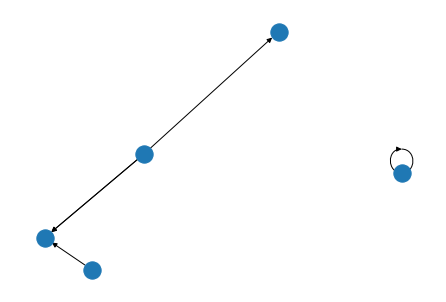

In [39]:


nx.draw(G, pos=nx.spring_layout(G))  # use spring layout

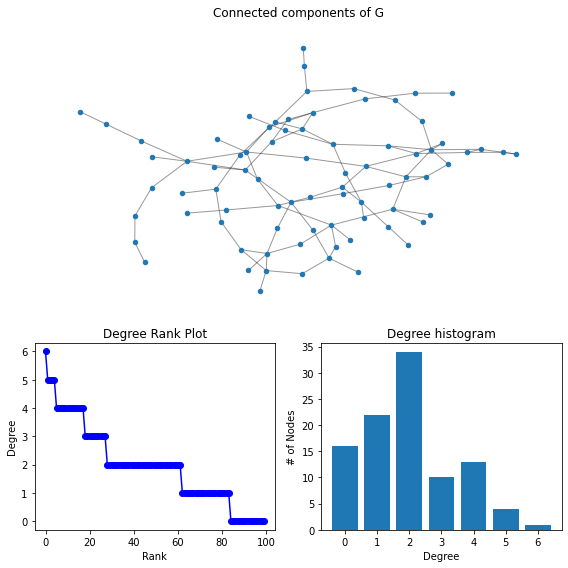

In [47]:
G = nx.gnp_random_graph(100, 0.02, seed=10374196)

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()